
# Analyzing e-commerece reviews using deep neural network based on big data techniques


We must make use of various Technologies as Hive Queries and  technigues as  **Multi-layers-Perceptron and  NaiveBayes** to find a connection between review and purchase of commodities. We shall make use of the various **functions and libraries** within pyspark itself.




# Step 1 - Import Spark Session and Initialize Spark

Let's begin with loading all the necessary modules in the system.

- **SparkContext** and **SparkConf** from **pyspark** to create a **Spark Instance**

- **SparkSession** from **pyspark.sql** to work with the **SparkSession**

- **IntegerType and DoubleType** from **pyspark.sql.types** to convert datatypes

- **mean, stddev, col and when** from **pyspark.sql.functions** for stats

- **mode** from **statistics** to calculate the mode

- **StringIndexer and VectorAssembler** from **pyspark.ml.feature** to perform one-hot encoding and making a feature vector

- **LogisticRegression, DecisionTreeClassifier, RandomForestClassifier and GBTClassifier** from **pyspark.ml.classification** for Machine Learning Classifiers

- **Pipeline** from **pyspark.ml** to sequence tasks one in an orderly way

- **MulticlassClassificationEvaluator** from **pyspark.ml.evaluation** to evaluate Machine Learning model's performance

- **MulticlassMetrics** from **pyspark.mllib.evaluation** to get the prediction performance of the model

- **MLUtils** from **pyspark.mllib.util** to support MulticlassMetrics

- **seaborn** for good visuaizations

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# loading relevant libraries

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import seaborn as sns

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a **Spark session** which will the configuration of our Spark **environment** and a **Spark Context** which will store this config.

Check if the `spark_context` has been created or not. If not, we will initialize the Spark session with the previously defined `spark_context` variable. 

In [ ]:
spark_context = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context

if (spark_context is None):
    spark_context = SparkContext(master = "local[4]", appName = "Project")
spark = SparkSession(sparkContext = spark_context)

# Step 2 - Load the Dataset and Print the Schema and Total Number of Entries

Making use of the `spark.read.csv` function, we read in the amazon data file. Let's store it in `amazon_pred`.

In [ ]:
amazon_pred = spark.read.csv('amazon.tsv', inferSchema = True, header = True ,sep='\t')


Let's display the first 10 rows of the dataset to get an idea about the data.

In [1]:
amazon_pred.show(10)

NameError: ignored

Check to see if Ssme of the columns contains Null values that must either be fixed or removed from our dataset. Printing the number of lines in the dataset, we get.

In [ ]:
print('Total number of lines in the Amazon Review Data is : ' + str(amazon_pred.count()))

Total number of lines in the Amazon Review Data is : 3150


# Step 3 - Reduce Columns from the Dataset  

Sometimes, when there are many **NULL values in a column**, the best option, keeping that we have a prediction task at hand, is to remove them. Keeping that particular column will only **negatively affect our prediction** and has to go. Therefore, as instructed in the specification, we are dropping the following columns :

- rating
- date
- variation
- verified_views
- feedback


In [ ]:
amazon_pred = amazon_pred.drop('date')

Let's inspect to see if they are really gone or not.

In [ ]:
amazon_pred.show(20)

+------+-------------------+--------------------+--------+
|rating|          variation|    verified_reviews|feedback|
+------+-------------------+--------------------+--------+
|     5|    Charcoal Fabric|       Love my Echo!|       1|
|     5|    Charcoal Fabric|           Loved it!|       1|
|     4|      Walnut Finish|Sometimes while p...|       1|
|     5|    Charcoal Fabric|I have had a lot ...|       1|
|     5|    Charcoal Fabric|               Music|       1|
|     5|Heather Gray Fabric|I received the ec...|       1|
|     3|   Sandstone Fabric|Without having a ...|       1|
|     5|    Charcoal Fabric|I think this is t...|       1|
|     5|Heather Gray Fabric|         looks great|       1|
|     5|Heather Gray Fabric|Love it! I’ve lis...|       1|
|     5|    Charcoal Fabric|I sent it to my 8...|       1|
|     5|    Charcoal Fabric|I love it! Learni...|       1|
|     5|         Oak Finish|I purchased this ...|       1|
|     5|    Charcoal Fabric|  Love, Love, Love!!|       

In [ ]:
amazon_pred.columns

['rating', 'variation', 'verified_reviews', 'feedback']

We have only retained the columns that will be useful to us for making predictions.

# Step 4 - (MAPPER)Print the Number of Missing Data in each Column

In this task, we must display the number of **null values in each column**. As this is something that we will be using on multiple ocassions in our assignment, it only makes sense to make a function, we will call it `missing`.

In [ ]:
def missing():
    
    for columns in amazon_pred.columns:
        print(columns + ' has number of NULLs : ' + str(amazon_pred[amazon_pred[columns] == 'NA'].count()))

In [ ]:
missing()

rating has number of NULLs : 0
variation has number of NULLs : 0
verified_reviews has number of NULLs : 0
feedback has number of NULLs : 0


We have the count of all the Null values in our dataset

# Step 5 - Fill the Missing Data with Average Value and Maximum Occurrence  Value

Here, we are asked to fill the missing values in our dataset. It's simple, if it's a **numerical column**, then we simply replace it with the **average of that column**. If it's a **categorical column**, we replace it by the **maximum frequency value**.

For this task, let's run a loop over all the columns in our dataset to see their datatypes.

In [ ]:
for columns in amazon_pred.columns:
    
    print('The datatype of ' + str(columns) + ' ' + str(type(columns)))

The datatype of rating <class 'str'>
The datatype of variation <class 'str'>
The datatype of verified_reviews <class 'str'>
The datatype of feedback <class 'str'>


Everything is string! Not very helpful, is it? Let's try and calculate the **average** of each column anyway. If it turns out to be a number then we know that column is **numeric**, otherwise it's **categorical**.

In [ ]:
from pyspark.sql.functions import mean as _mean
#from statistics import mode as _mode
for columns in amazon_pred.columns:
    print(amazon_pred.select(_mean(col(columns))).collect())

[Row(avg(rating)=4.463174603174603)]
[Row(avg(variation)=None)]
[Row(avg(verified_reviews)=None)]
[Row(avg(feedback)=0.9184126984126985)]


We will call the `missing()` again, which we made earlier instead of writing the code again and again

In [ ]:
missing()

rating has number of NULLs : 0
variation has number of NULLs : 0
verified_reviews has number of NULLs : 0
feedback has number of NULLs : 0


**No Null values** in the **numerical columns**! Moving on to the **categorical columns**.

## For Categorical Columns Using HiveQL Commands

Things will be a bit different here, we shall use hive command `.groupBy()`, `.count()`, `orderBy()` and `.sort()` methods on our dataset to firstly see, and then change their values in the dataset.

In [ ]:
amazon_pred.groupBy('rating').count().orderBy('rating').sort('count', ascending = False).show()

+------+-----+
|rating|count|
+------+-----+
|     5| 2286|
|     4|  455|
|     1|  161|
|     3|  152|
|     2|   96|
+------+-----+



In [ ]:
amazon_pred.groupBy('variation').count().orderBy('variation').sort('count', ascending = False).show()

+--------------------+-----+
|           variation|count|
+--------------------+-----+
|          Black  Dot|  516|
|     Charcoal Fabric|  430|
|Configuration: Fi...|  350|
|         Black  Plus|  270|
|         Black  Show|  265|
|               Black|  261|
|         Black  Spot|  241|
|          White  Dot|  184|
| Heather Gray Fabric|  157|
|         White  Spot|  109|
|               White|   91|
|    Sandstone Fabric|   90|
|         White  Show|   85|
|         White  Plus|   78|
|          Oak Finish|   14|
|       Walnut Finish|    9|
+--------------------+-----+



In [ ]:
amazon_pred.groupBy('feedback').count().orderBy('feedback').sort('count', ascending = False).show()

+--------+-----+
|feedback|count|
+--------+-----+
|       1| 2893|
|       0|  257|
+--------+-----+



In [ ]:
amazon_pred.groupBy('verified_reviews').count().orderBy('verified_reviews').sort('count', ascending = False).show()

+----------------+-----+
|verified_reviews|count|
+----------------+-----+
|            null|   79|
|        Love it!|   22|
|         Love it|   19|
|   Great product|   11|
|           Great|    9|
|    Works great!|    8|
|       I love it|    7|
|         love it|    5|
|       I like it|    5|
| Easy to set up.|    4|
|         Perfect|    4|
|     I love it!!|    4|
|     Easy set up|    4|
|  Really like it|    4|
|            Cool|    4|
|        It works|    3|
|      I love it.|    3|
|            Good|    3|
|      Everything|    3|
|     Works great|    3|
+----------------+-----+
only showing top 20 rows



Here, we shall make use of the `.groupBy()`, `.count()`, `orderBy()` and `.sort()` methods on our dataset to firstly see, and then change their values in the dataset.



In [ ]:
product_parent_mode = amazon_pred.groupBy('rating').count().orderBy('rating').sort('count', ascending = False).collect()[0][0]
product_parent_mode

5

In [ ]:
star_rating_mode = amazon_pred.groupBy('variation').count().orderBy('variation').sort('count', ascending = False).collect()[0][0]
star_rating_mode

'Black  Dot'

In [ ]:
total_votes_mode = amazon_pred.groupBy('feedback').count().orderBy('feedback').sort('count', ascending = False).collect()[0][0]
total_votes_mode

1

All nulls are gone! We can now move on to some basic datatype transformations which we can directly feed into the Deep Learning algorithm.

# Step 6 - Data Transformation  Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm.







We are going to import the daset into pandas to carry out EDA data analysis



In [ ]:
amazon_prediction = pd.read_csv("amazon.tsv",sep='\t')


In [ ]:
amazon_prediction.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [ ]:
amazon_prediction.sample(5)

,rating,date,variation,verified_reviews,feedback
633,5,29-May-18,Black,It’s amazing I love it,1
2536,3,30-Jul-18,Black Dot,"No problems, works as expected. Could have a b...",1
266,5,29-Jul-18,Charcoal Fabric,It’s smaller than the original. Looks nicer too.,1
1804,5,29-Jul-18,Black Plus,Not perfect but very good! A few times Alexa p...,1
398,1,19-Jul-18,Black,Dont trust this....,0


Let's see get some information on the dataframe

In [ ]:
amazon_prediction.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3071 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [ ]:
#check if columns have whitespaces
space_cols = [columns for numerical_list in amazon_prediction.columns if re.findall('\s*', columns) != []]
space_cols

['feedback', 'feedback', 'feedback', 'feedback', 'feedback']

In [ ]:
#check if columns have special characters other than letter
non_alnum = [columns for numerical_list in amazon_prediction.columns if re.findall('[^a-zA-Z0-9\s]', columns) != []]
non_alnum

[]

We are going to visualize the dataframe to give us a visual insight on the data tha we are to analyze

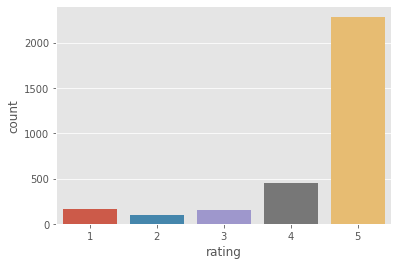

In [ ]:
sns.countplot(x='rating', data=amazon_prediction)
plt.savefig('rating_count.jpg', dpi=300, quality=80, optimize=True, progressive=True)

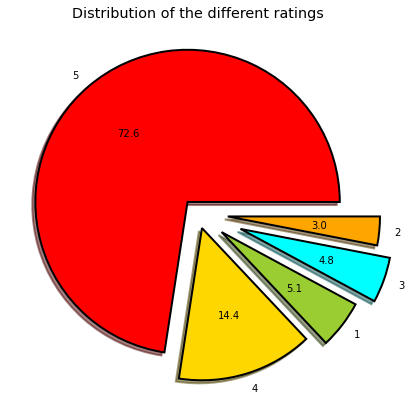

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ("red","gold","yellowgreen","cyan","orange")
wp = {'linewidth':2, 'edgecolor':'black'}
tags = amazon_prediction['rating'].value_counts()
explode = (0.1,0.1,0.2,0.3,0.2)
tags.plot(kind='pie', autopct='%1.1f',colors=colors, shadow=True,
          startangle=0, wedgeprops=wp, explode=explode, label='')
plt.title('Distribution of the different ratings')
plt.savefig('Customer_rating.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

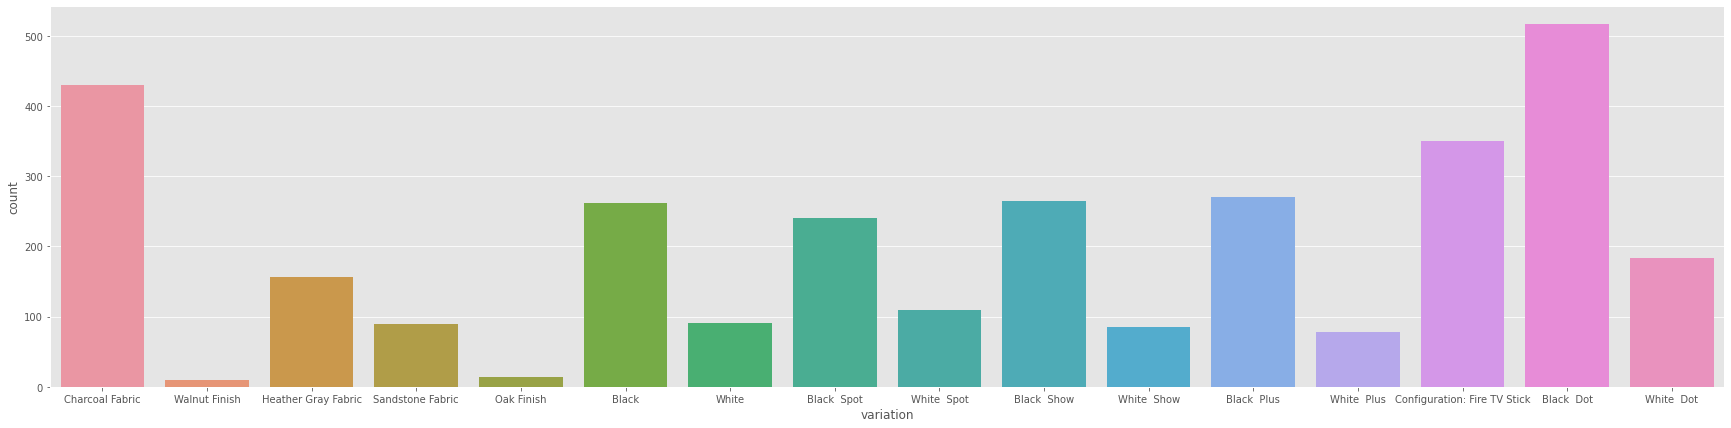

In [ ]:
fig = plt.figure(figsize=(30,7))
sns.countplot(x="variation",data=amazon_prediction)
plt.savefig('variation_distribution.jpg', dpi=300, quality=80, optimize=True, progressive=True)

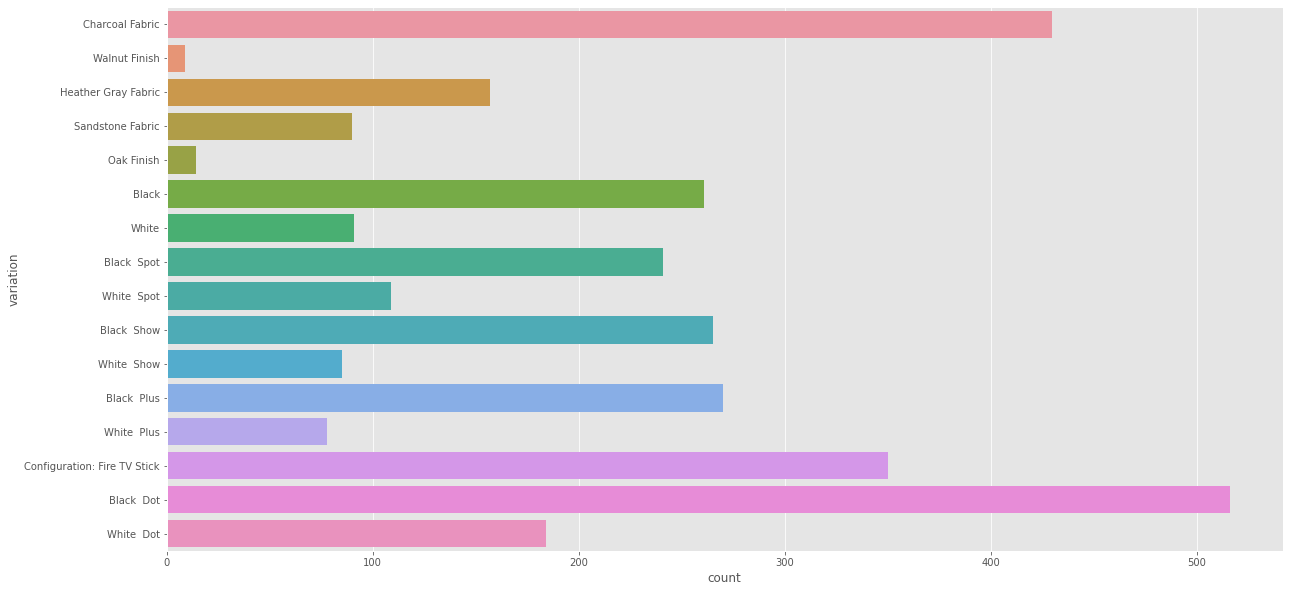

In [ ]:

fig = plt.figure(figsize=(20,10))
sns.countplot(y="variation",data=amazon_prediction)
plt.savefig('variation_distribution2.jpg', dpi=300, quality=80, optimize=True, progressive=True)


In [ ]:
amazon_prediction['variation'].value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

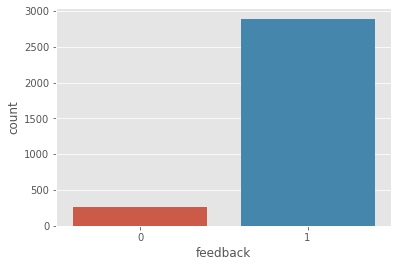

In [ ]:
sns.countplot(x='feedback', data=amazon_prediction)
plt.savefig('feedback_distribution2.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

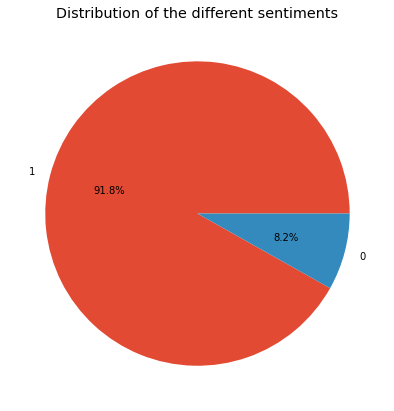

In [ ]:
fig = plt.figure(figsize=(7,7))
tags = amazon_prediction['feedback'].value_counts()
tags.plot(kind='pie', autopct='%1.1f%%', label='')
plt.title("Distribution of the different sentiments")
plt.savefig('sentiment_distribution2.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

In [ ]:


for i in range(5):
    print(amazon_prediction['verified_reviews'].iloc[i],"\n")



Love my Echo! 

Loved it! 

Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. 

I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. 

Music 



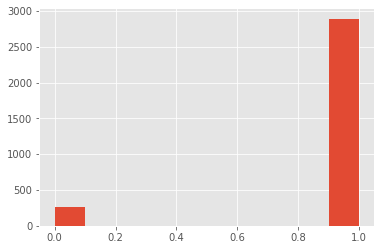

In [ ]:
amazon_prediction['feedback'].hist()

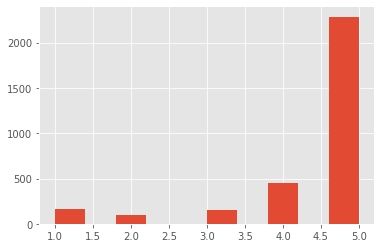

In [ ]:
amazon_prediction['rating'].hist()


# Step 7 - Drop off unnecessary features and Divide the Dataset

In [ ]:
amazon_prediction = amazon_prediction.drop(labels=['rating','date'],axis=1)


In [ ]:
amazon_prediction

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1
...,...,...,...
3145,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,Black Dot,"Listening to music, searching locations, check...",1
3147,Black Dot,"I do love these things, i have them running my...",1
3148,White Dot,Only complaint I have is that the sound qualit...,1


Here we are encoding 'variation' column


In [ ]:
variation_dummies = pd.get_dummies(amazon_prediction['variation'])

Creating a target and its predictors

In [ ]:
x_df = amazon_prediction['verified_reviews'].fillna(' ')

y_df = amazon_prediction['feedback'].fillna(' ')



Extracting vocabulary for posterior tokenization

Removing unnecessary words!


In [ ]:


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split



vect = CountVectorizer(stop_words='english')

text_vectorizer = vect.fit_transform(x_df)

arr = vect.get_feature_names_out()
forbidden = ['0','1','2','3','4','5','6','7','8','9','_','+',"-",'@','ü','ò','û','$','%','*','#','/','â','!','[',']','.',';','ç','>','å','ñ','¿'
                ,'¡','ü','á','ó','ú','á','ú','í'] 
stop = []
i = -1
for item in arr:
  i = i+1
  for letter in item:
    if letter in forbidden:
      stop.append(item)
          
for item in arr:
  if len(item)>15 or item[0]=='x' or len(item)<=2 or (item == len(item) * item[0]):
    stop.append(item)
print(len(stop))



298


In [ ]:
for item in arr:
  if item == 'lov':
    print(item)
    item = 'love'

lov


With set operations, deleting unnecessary words

In [ ]:
vocab = set(arr) - set(stop)
len(vocab)


3615

Final tokenization with the correct vocabulary

In [ ]:
final_vectorizer = CountVectorizer(stop_words='english',vocabulary=vocab)
result = final_vectorizer.fit_transform(x_df)
text_df = pd.DataFrame(result.toarray(),columns=final_vectorizer.get_feature_names())
final_df = pd.concat([variation_dummies,text_df],axis=1)
final_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,york,young,younger,youngest,youtube,yrs,yup,zero,zigbee,zonked
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Step 8 - Train Test Split and  Calculating the confusion matrix and find the precision, recall, and F1 score of each classification algorithm.

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(text_df,y_df)

**Experimenting with GaussianNaiveBayes**

Cross-validating results

In [ ]:

params={'var_smoothing': np.logspace(0,-9, num=100) }
smt = SMOTE()
naive_grid = GridSearchCV(GaussianNB(),param_grid=params,refit=True)
naive_pipe = make_pipeline(smt,naive_grid)
x_train,x_test,y_train,y_test = train_test_split(text_df,y_df)
naive_pipe.fit(x_train,y_train)



Pipeline(steps=[('smote', SMOTE()),
                ('gridsearchcv',
                 GridSearchCV(estimator=GaussianNB(),
                              param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])}))])

In [ ]:
pd.DataFrame(naive_pipe[1].cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.310110,0.006650,0.068722,0.001574,0.000658,{'var_smoothing': 0.0006579332246575676},0.792388,0.795848,0.816397,0.827945,0.810624,0.808640,0.013150,1
36,0.312157,0.004886,0.067349,0.001293,0.000534,{'var_smoothing': 0.0005336699231206307},0.792388,0.794694,0.815242,0.826790,0.809469,0.807717,0.012869,2
37,0.306329,0.003080,0.068294,0.001879,0.000433,{'var_smoothing': 0.0004328761281083057},0.792388,0.792388,0.812933,0.825635,0.808314,0.806331,0.012720,3
38,0.303758,0.003092,0.067975,0.001125,0.000351,{'var_smoothing': 0.0003511191734215131},0.792388,0.792388,0.812933,0.823326,0.808314,0.805870,0.012034,4
39,0.303467,0.001717,0.068310,0.001888,0.000285,{'var_smoothing': 0.0002848035868435802},0.792388,0.792388,0.811778,0.823326,0.807159,0.805408,0.011864,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.306263,0.004343,0.069353,0.001782,0.432876,{'var_smoothing': 0.43287612810830584},0.519031,0.522491,0.534642,0.519630,0.516166,0.522392,0.006446,96
3,0.313881,0.008672,0.071008,0.005322,0.53367,{'var_smoothing': 0.533669923120631},0.516724,0.517878,0.533487,0.519630,0.508083,0.519161,0.008195,97
2,0.316157,0.007564,0.069367,0.000687,0.657933,{'var_smoothing': 0.657933224657568},0.515571,0.515571,0.524249,0.510393,0.504619,0.514081,0.006496,98
1,0.306066,0.006682,0.069625,0.003363,0.811131,{'var_smoothing': 0.8111308307896871},0.508651,0.509804,0.519630,0.508083,0.503464,0.509926,0.005310,99


In [ ]:
y_pred = naive_pipe.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.14      0.62      0.22        61
           1       0.95      0.67      0.79       727

    accuracy                           0.66       788
   macro avg       0.55      0.65      0.50       788
weighted avg       0.89      0.66      0.74       788



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


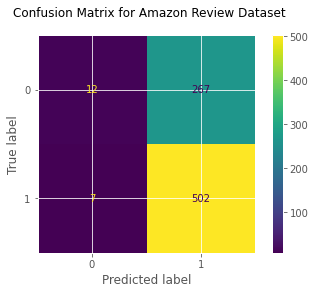

In [ ]:
fig = plot_confusion_matrix(neural_model, x_test, y_pred)
fig.figure_.suptitle("Confusion Matrix for Amazon Review Dataset")
plt.savefig('matrix1.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

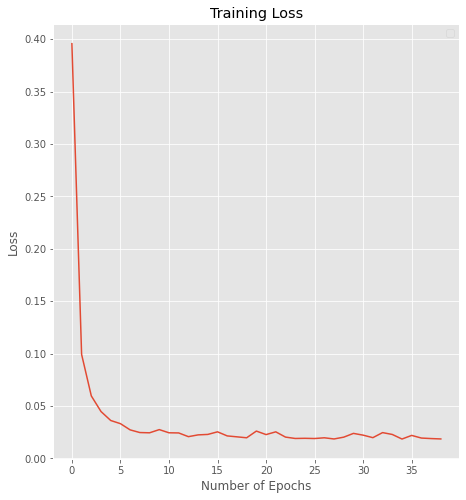

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(neural_model.loss_curve_)
plt.title('Training Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig('loss1.jpg', dpi=300, quality=80, optimize=True, progressive=True)

plt.legend()
plt.show()

#Experimenting with oversampling tools: RandomOverSampler and GaussianNaiveBayes

In [ ]:
naive_grid = GridSearchCV(GaussianNB(),param_grid=params,refit=True)
naive_pipe = make_pipeline(RandomOverSampler(),naive_grid)
x_train,x_test,y_train,y_test = train_test_split(text_df,y_df)
naive_pipe.fit(x_train,y_train)

Pipeline(steps=[('randomoversampler', RandomOverSampler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=GaussianNB(),
                              param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])}))])

In [ ]:
y_pred = naive_pipe.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.24      0.71      0.36        58
           1       0.97      0.82      0.89       730

    accuracy                           0.82       788
   macro avg       0.61      0.77      0.63       788
weighted avg       0.92      0.82      0.85       788



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


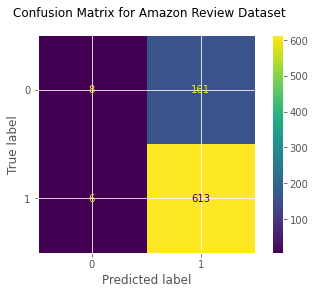

In [ ]:
fig = plot_confusion_matrix(neural_model, x_test, y_pred)
fig.figure_.suptitle("Confusion Matrix for Amazon Review Dataset")
plt.savefig('matrix2.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

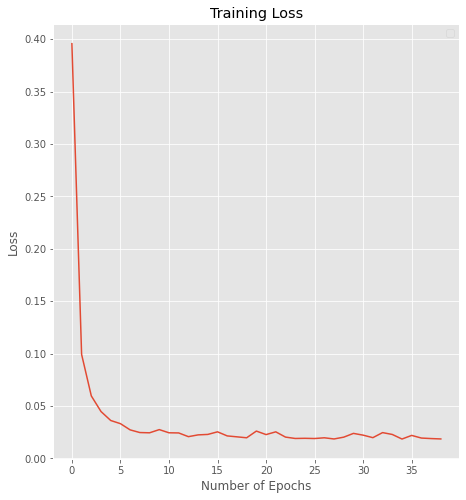

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(neural_model.loss_curve_)
plt.title('Training Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig('loss2.jpg', dpi=300, quality=80, optimize=True, progressive=True)

plt.legend()
plt.show()

# Neural Networks: Without oversampling and scaling

In [ ]:
neural_model = MLPClassifier(hidden_layer_sizes=(400,400),activation='relu',verbose=1,solver='adam')
neural_model.fit(x_train,y_train)

Iteration 1, loss = 0.43141035
Iteration 2, loss = 0.24449129
Iteration 3, loss = 0.15958913
Iteration 4, loss = 0.11244906
Iteration 5, loss = 0.07701271
Iteration 6, loss = 0.04958639
Iteration 7, loss = 0.03423450
Iteration 8, loss = 0.02633259
Iteration 9, loss = 0.02253912
Iteration 10, loss = 0.02041445
Iteration 11, loss = 0.01934095
Iteration 12, loss = 0.01921451
Iteration 13, loss = 0.01937795
Iteration 14, loss = 0.01833922
Iteration 15, loss = 0.01793898
Iteration 16, loss = 0.01763072
Iteration 17, loss = 0.01744641
Iteration 18, loss = 0.01739685
Iteration 19, loss = 0.01749423
Iteration 20, loss = 0.01746430
Iteration 21, loss = 0.01724037
Iteration 22, loss = 0.01712129
Iteration 23, loss = 0.01747722
Iteration 24, loss = 0.01706833
Iteration 25, loss = 0.01760631
Iteration 26, loss = 0.01742314
Iteration 27, loss = 0.01774433
Iteration 28, loss = 0.01773436
Iteration 29, loss = 0.01682593
Iteration 30, loss = 0.01740776
Iteration 31, loss = 0.01711733
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(400, 400), verbose=1)

In [ ]:
y_pred = neural_model.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.41      0.54        58
           1       0.96      0.99      0.97       730

    accuracy                           0.95       788
   macro avg       0.86      0.70      0.76       788
weighted avg       0.94      0.95      0.94       788



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


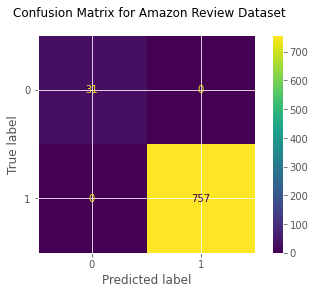

In [ ]:
fig = plot_confusion_matrix(neural_model, x_test, y_pred)
fig.figure_.suptitle("Confusion Matrix for Amazon Review Dataset")
plt.savefig('matrix3.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

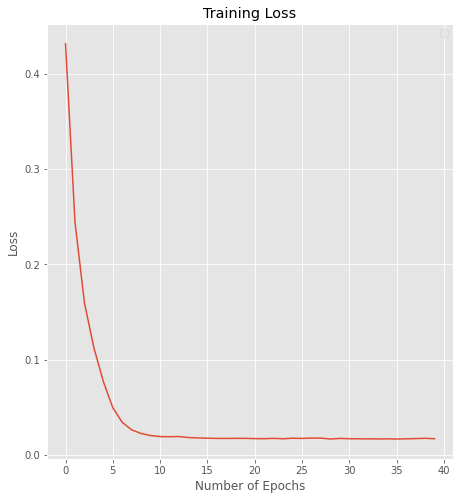

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(neural_model.loss_curve_)
plt.title('Training Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig('loss3.jpg', dpi=300, quality=80, optimize=True, progressive=True)

plt.legend()
plt.show()


#Neural Networks: With oversampler (RandomOverSamppler), WITHOUT scaling

In [ ]:
neural_pipe = make_pipeline(RandomOverSampler(),neural_model)
neural_pipe.fit(x_train,y_train)

Iteration 1, loss = 0.43636936
Iteration 2, loss = 0.08606769
Iteration 3, loss = 0.04415218
Iteration 4, loss = 0.03549682
Iteration 5, loss = 0.03223835
Iteration 6, loss = 0.03104287
Iteration 7, loss = 0.03114685
Iteration 8, loss = 0.03031303
Iteration 9, loss = 0.03088808
Iteration 10, loss = 0.03042440
Iteration 11, loss = 0.02990018
Iteration 12, loss = 0.03008937
Iteration 13, loss = 0.02942065
Iteration 14, loss = 0.03043982
Iteration 15, loss = 0.03041015
Iteration 16, loss = 0.02975166
Iteration 17, loss = 0.02989586
Iteration 18, loss = 0.02989469
Iteration 19, loss = 0.03014309
Iteration 20, loss = 0.02932607
Iteration 21, loss = 0.03001213
Iteration 22, loss = 0.03233933
Iteration 23, loss = 0.02972578
Iteration 24, loss = 0.02980466
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('randomoversampler', RandomOverSampler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(400, 400), verbose=1))])

In [ ]:
y_pred = neural_pipe.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.45      0.46        58
           1       0.96      0.96      0.96       730

    accuracy                           0.92       788
   macro avg       0.72      0.70      0.71       788
weighted avg       0.92      0.92      0.92       788



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


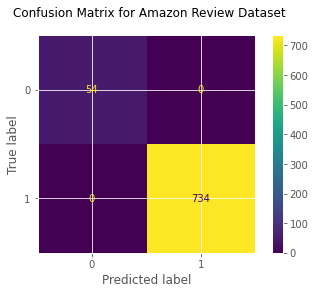

In [ ]:
fig = plot_confusion_matrix(neural_model, x_test, y_pred)
fig.figure_.suptitle("Confusion Matrix for Amazon Review Dataset")
plt.savefig('matrix4.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

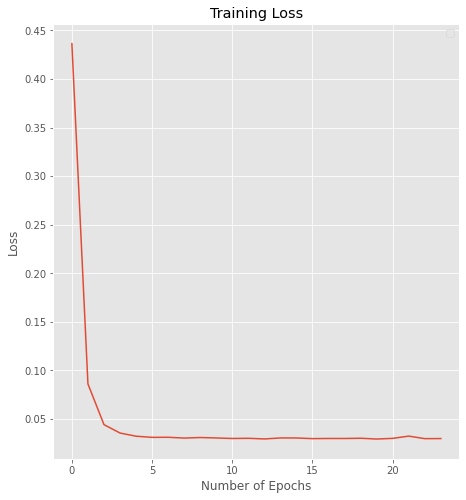

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(neural_model.loss_curve_)
plt.title('Training Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig('loss4.jpg', dpi=300, quality=80, optimize=True, progressive=True)

plt.legend()
plt.show()

#Neural Networks: With oversampling (SMOTE()) and scaling(StandardScaler)

In [ ]:
neural_pipe = make_pipeline(SMOTE(),StandardScaler(),neural_model)
neural_pipe.fit(x_train,y_train)



Iteration 1, loss = 0.45802678
Iteration 2, loss = 0.15838693
Iteration 3, loss = 0.08053445
Iteration 4, loss = 0.06616886
Iteration 5, loss = 0.06271496
Iteration 6, loss = 0.06168641
Iteration 7, loss = 0.06105436
Iteration 8, loss = 0.07819606
Iteration 9, loss = 0.06592332
Iteration 10, loss = 0.05801515
Iteration 11, loss = 0.06289677
Iteration 12, loss = 0.06008808
Iteration 13, loss = 0.05909563
Iteration 14, loss = 0.05904355
Iteration 15, loss = 0.05771083
Iteration 16, loss = 0.05747491
Iteration 17, loss = 0.05848359
Iteration 18, loss = 0.05686670
Iteration 19, loss = 0.05871241
Iteration 20, loss = 0.05711187
Iteration 21, loss = 0.05721887
Iteration 22, loss = 0.05605703
Iteration 23, loss = 0.05549661
Iteration 24, loss = 0.05782702
Iteration 25, loss = 0.05688373
Iteration 26, loss = 0.05756151
Iteration 27, loss = 0.06094580
Iteration 28, loss = 0.05823801
Iteration 29, loss = 0.05772492
Iteration 30, loss = 0.05530894
Iteration 31, loss = 0.05849895
Iteration 32, los

Pipeline(steps=[('smote', SMOTE()), ('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(400, 400), verbose=1))])

In [ ]:
y_pred = neural_pipe.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.55      0.46        58
           1       0.96      0.93      0.95       730

    accuracy                           0.90       788
   macro avg       0.68      0.74      0.70       788
weighted avg       0.92      0.90      0.91       788



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


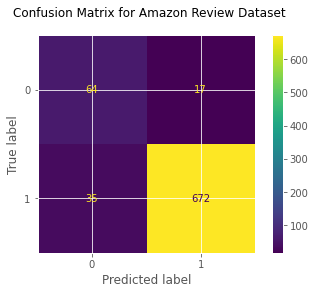

In [ ]:
fig = plot_confusion_matrix(neural_model, x_test, y_pred)
fig.figure_.suptitle("Confusion Matrix for Amazon Review Dataset")
plt.savefig('matrix5.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()

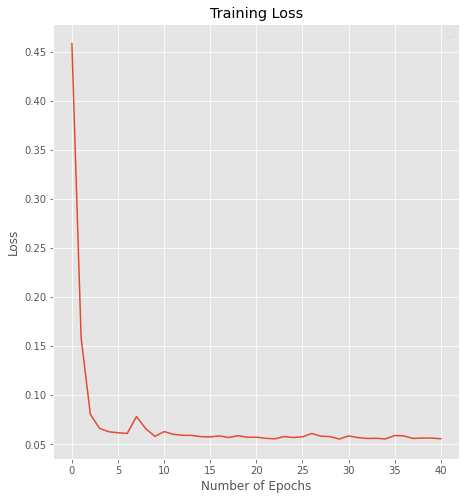

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(neural_model.loss_curve_)
plt.title('Training Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig('loss5.jpg', dpi=300, quality=80, optimize=True, progressive=True)

plt.legend()
plt.show()

#Neural Networks: Without oversampling and with scaling

In [ ]:
neural_pipe = make_pipeline(StandardScaler(),neural_model)
neural_pipe.fit(x_train,y_train)

Iteration 1, loss = 0.36507611
Iteration 2, loss = 0.10504881
Iteration 3, loss = 0.06002884
Iteration 4, loss = 0.04154354
Iteration 5, loss = 0.03488564
Iteration 6, loss = 0.02753917
Iteration 7, loss = 0.02620993
Iteration 8, loss = 0.02421972
Iteration 9, loss = 0.02052708
Iteration 10, loss = 0.01991171
Iteration 11, loss = 0.01950505
Iteration 12, loss = 0.01968930
Iteration 13, loss = 0.02304193
Iteration 14, loss = 0.02335412
Iteration 15, loss = 0.02017011
Iteration 16, loss = 0.01864326
Iteration 17, loss = 0.03115590
Iteration 18, loss = 0.02404455
Iteration 19, loss = 0.01970249
Iteration 20, loss = 0.02012830
Iteration 21, loss = 0.01920387
Iteration 22, loss = 0.02066456
Iteration 23, loss = 0.01989670
Iteration 24, loss = 0.02114874
Iteration 25, loss = 0.01867699
Iteration 26, loss = 0.02280113
Iteration 27, loss = 0.02008352
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(400, 400), verbose=1))])

In [ ]:
y_pred = neural_pipe.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        58
           1       0.96      0.98      0.97       730

    accuracy                           0.95       788
   macro avg       0.82      0.74      0.77       788
weighted avg       0.94      0.95      0.94       788



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


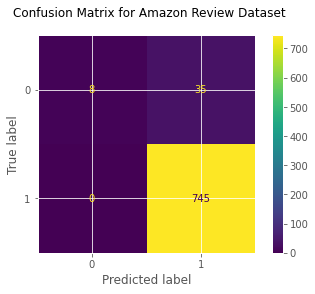

In [ ]:
fig = plot_confusion_matrix(neural_model, x_test, y_pred)
fig.figure_.suptitle("Confusion Matrix for Amazon Review Dataset")
plt.savefig('matrix6.jpg', dpi=300, quality=80, optimize=True, progressive=True)
plt.show()


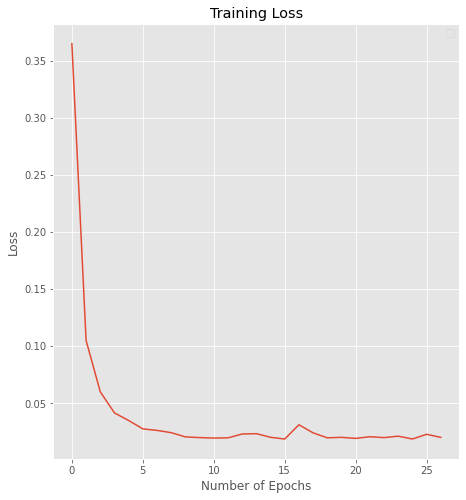

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(neural_model.loss_curve_)
plt.title('Training Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig('loss6.jpg', dpi=300, quality=80, optimize=True, progressive=True)  

plt.legend()
plt.show()

# Step 09: Explain how the loss of the prediction can be reduced for the accuracy to be better? 

## How can we reduce loss to improve accuracy?



There are two other ways which come to mind when we think about increasing the accuracy of the model :

1) **Hyperparameter tuning** is the process of tweaking and altering a set of parameters while measuring accuracy against it to determine the best set for a given problem.
Using **grid search,** which essentially uses a wide range of parameters for tweaking until the best set of parameters is identified," we can automate this. 

2. **Dealing with Highly Imbalanced Data**The initial Yes:No ratio in the training set is approximately 1:4, which is severely unbalanced because the class **Yes** label is much underrepresented compared to the class **No** label in this issue of predicting the RainTomorrow label.This may have an impact on the final model's prediction probability.Methods like **Prior Probability**, **Weighted Matrix**, etc. can be used to deal with this. 